#### This Notebook is for summarizing the Single Document 'Text Summarization' based on TFIDF Sentence scoring and Centroid Based Scoring System

In [17]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
import math
import os

In [18]:
stopwords_eng = stopwords.words('english')

In [19]:
df=pd.read_csv('train.csv')

In [20]:
def text_preprocessing(text):
    """This function will do following preprocessing
    1. Tokenizing the text into sentence.
    2. Word tokenization for each sentence tokens.
    3. Removing the stop words
    4. Removing the regular expression
    Output format: cleaned_text={'sent1':['word1','word2'....],'sent2':['w1,'w2','w3',..]}
     """
    sent_token=sent_tokenize(text)
    n=len(sent_token)
    cleaned_text={}
    for i in range(0,n):
        temp=[]
        w_t=word_tokenize(sent_token[i])
        w_t_s=[word for word in w_t if ((not word.lower() in stopwords_eng )and (len(word)>3))]
        for word in w_t_s:
            result = re.sub(r'[^a-zA-Z]', '',word)
            if result!='':
                temp.append(result)
            else:
                continue
        if len(temp)>2:
            cleaned_text[sent_token[i]]=temp
    return cleaned_text
    

In [21]:
def frequency_count(cleaned_text):
    """This function return the frequency of each word in the given sentence
    Input_argument:
                cleaned_text={'sent1':['word1','word2'....],'sent2':['w1,'w2','w3',..]}
    Output:
          freq_dict=[()]
    
    """
    freq_dict={}
    for i in cleaned_text.keys():
        freq_dict[i]={}
        for j in cleaned_text[i]:
            if j not in freq_dict[i].keys():
                freq_dict[i][j]=1
            else:
                freq_dict[i][j]=freq_dict[i][j]+1
                
    return freq_dict

In [22]:
def tf_score(cleaned_text,freq_dict):
    tf_dict={}
    for i in freq_dict.keys():
        tf_dict[i]={}
        for j in freq_dict[i].keys():
            tf_dict[i][j]=round(freq_dict[i][j]/len(cleaned_text[i]),3)
    return tf_dict

In [23]:
def doc_word_freq(cleaned_text):
    """This return how many times particular word appeared in the document"""
    doc_freq={}
    for i in cleaned_text.keys():
        doc_freq[i]={}
        for j in cleaned_text[i]:
            count=0
            if j not in doc_freq[i].keys():
                doc_freq[i][j]=0     
            else:
                continue
            for k in cleaned_text.keys():
                if j in cleaned_text[k]:
                    count=count+1
                else:
                    continue
            doc_freq[i][j]=count
    return doc_freq
            
                

In [24]:
def idf_score(cleaned_text,freq_dict):
    idf_dict={}
    doc_freq=doc_word_freq(cleaned_text)
    n_sent=len(freq_dict.keys())
    for i in freq_dict.keys():
        idf_dict[i]={}
        for j in freq_dict[i].keys():
            idf_dict[i][j]=math.log(n_sent/doc_freq[i][j])
    return idf_dict

In [25]:
def tf_idf_score(tf_dict,idf_dict):
    tf_idf_dict={}
    for i in tf_dict.keys():
        tf_idf_dict[i]={}
        for j in tf_dict[i].keys():
            tf_idf_dict[i][j]=tf_dict[i][j]*idf_dict[i][j]
    return tf_idf_dict

In [26]:
def sent_score(tf_idf_dict):
    sent_tfidf_dict={}
    for i in tf_idf_dict.keys():
        sum=0
        for j in tf_idf_dict[i].keys():
            sum=sum+tf_idf_dict[i][j]
        sent_tfidf_dict[i]=sum/len(tf_idf_dict[i].keys())
    return sent_tfidf_dict

In [27]:
def sent_avg_score(sent_tfidf_dict):
    avg_score=0
    n=len(sent_tfidf_dict.keys())
    sum=0
    for i in sent_tfidf_dict.keys():
        sum=sum+sent_tfidf_dict[i]
    avg_score=sum/n
    return avg_score
    

In [28]:
def summarize(sent_tfidf_dict,tuning_factor):
    summary=''
    summary_dict={}
    avg_score=sent_avg_score(sent_tfidf_dict)
    for i in sent_tfidf_dict.keys():
        if sent_tfidf_dict[i]>tuning_factor*avg_score:
            summary=summary+i
            
        
    return summary

In [29]:
def tfidf_summarizer(text,tuning_factor):
    cleaned_text=text_preprocessing(text)
    freq_dict=frequency_count(cleaned_text)
    tf_dict=tf_score(cleaned_text,freq_dict)
    doc_freq=doc_word_freq(cleaned_text)
    idf_dict=idf_score(cleaned_text,freq_dict)
    tf_idf_dict=tf_idf_score(tf_dict,idf_dict)
    sent_sc=sent_score(tf_idf_dict)
    summary=summarize(sent_sc,tuning_factor)
    return summary
    
    

In [30]:
def avg_centroid_score(centroid):
    sum=0
    for i in centroid.keys():
        sum=sum+centroid[i]
    avg_score=sum/len(centroid.keys())
    return avg_score

In [31]:
def text_centroid(tf_idf_dict):
    centroid={}
    new_centroid={}
    for i in tf_idf_dict.keys():
        for j in tf_idf_dict[i].keys():
            if j not in centroid.keys():
                centroid[j]=tf_idf_dict[i][j]
            else:
                centroid[j]=tf_idf_dict[i][j]+centroid[j]
    avg_score=avg_centroid_score(centroid)
    for i in centroid.keys():
        if centroid[i]>avg_score:
            new_centroid[i]=centroid[i]
        else:
            continue
    
    return new_centroid

In [32]:
def sent_cos_similarity(tf_idf_dict):
    new_centroid=text_centroid(tf_idf_dict)
    sent_similarity={}
    mod_centroid=0
    sq_sum=0
    for i in new_centroid.keys():
        sq_sum=sq_sum+new_centroid[i]**2
    mod_centroid=math.sqrt(sq_sum)
    for j in tf_idf_dict.keys():
        mod_sent=0
        sq_sum=0
        dot_product=0
        for k in tf_idf_dict[j].keys():
            sq_sum=sq_sum+tf_idf_dict[j][k]**2
            if k in new_centroid.keys():
                dot_product=dot_product+tf_idf_dict[j][k]*new_centroid[k]
        mod_sent=math.sqrt(sq_sum)
        sent_similarity[j]=round(dot_product/(mod_centroid*mod_sent),3)
            
    return sent_similarity

In [33]:
def avg_sent_similarity(sent_similarity):
    n=len(sent_similarity.keys())
    sum=0
    for i in sent_similarity:
        sum=sum+sent_similarity[i]
    avg_score=sum/n
    
    return avg_score
        

In [34]:
def centroid_summary_gen(sent_similarity,tuning_factor):
    avg_score=avg_sent_similarity(sent_similarity)
    summary=''
    for i in sent_similarity:
        if sent_similarity[i]>tuning_factor*avg_score:
            summary=summary+str(i)
        else:
            continue
    return summary

In [35]:
def ROUGE_1(sys_summarized_text,ref_summarized_text):
    sys_text=text_preprocessing(sys_summarized_text)
    ref_text=text_preprocessing(ref_summarized_text)
    sys_word=[]
    ref_word=[]
    match_count=0
    for i in sys_text.keys():
        for j in sys_text[i]:
            sys_word.append(j)
    for i in ref_text.keys():
        for j in ref_text[i]:
            ref_word.append(j)
    n=len(ref_word)
    for i in sys_word:
        for j in range(len(ref_word)):
            if i==ref_word[j]:
                match_count=match_count+1
                ref_word.pop(j)
                break
            else:
                continue
    if n>0:
        ROUGE=match_count/n
    else:
        ROUGE=0
    return ROUGE

In [36]:
def centroid_summarizer(text,tuning_factor):
    cleaned_text=text_preprocessing(text)
    freq_dict=frequency_count(cleaned_text)
    tf_dict=tf_score(cleaned_text,freq_dict)
    doc_freq=doc_word_freq(cleaned_text)
    idf_dict=idf_score(cleaned_text,freq_dict)
    tf_idf_dict=tf_idf_score(tf_dict,idf_dict)
    centroid=text_centroid(tf_idf_dict)
    sent_similarity=sent_cos_similarity(tf_idf_dict)
    summary=centroid_summary_gen(sent_similarity,tuning_factor)
    return summary

In [40]:
## Whole text as summary
n=len(df)
ROUGE_dict_max={}
sum=0
for i in range(n):
    tuning_factor=0  #ange (1 to 1.2)
    ref_summarized_text=df['highlights'][i]
    sys_summarized_text=tfidf_summarizer(df['article'][i],tuning_factor)
    #print('id',df['id'][i])
    #print('summary\n',sys_summarized_text)
    #print('\n')
    ROUGE=ROUGE_1(sys_summarized_text,ref_summarized_text)
    ROUGE_dict_max[df['id'][i]]=ROUGE
    sum=sum+ROUGE
print('ROUGE_avg_score_max(If whole text as summary):',sum/n)

ROUGE_avg_score_max(If whole text as summary): 0.7591292803668571


In [42]:
## TFidf based summary evaluation

n=len(df)
ROUGE_dict_tfidf={}
sum=0
for i in range(n):
    tuning_factor=1.1 # Range (1 to 1.2)
    ref_summarized_text=df['highlights'][i]
    sys_summarized_text=tfidf_summarizer(df['article'][i],tuning_factor)
    ROUGE=ROUGE_1(sys_summarized_text,ref_summarized_text)
    ROUGE_dict_tfidf[df['id'][i]]=ROUGE
    sum=sum+ROUGE
print('ROUGE_avg_score_tfidf:',sum/n)

ROUGE_avg_score_tfidf: 0.1896838980882692


In [43]:
## centroid based summary 
n=len(df)
ROUGE_dict_centroid={}
sum=0
for i in range(n):
    tuning_factor=1.1 ## Range (1 to 1.2)
    ref_summarized_text=df['highlights'][i]
    sys_summarized_text=centroid_summarizer(df['article'][i],tuning_factor)
    ROUGE=ROUGE_1(sys_summarized_text,ref_summarized_text)
    ROUGE_dict_centroid[df['id'][i]]=ROUGE
    sum=sum+ROUGE
print('ROUGE_avg_Score_centroid',sum/n)

ROUGE_avg_Score_centroid 0.4204972538946604


In [44]:
index=0
Y_max=[]
Y_centroid=[]
Y_tfidf=[]
X=[]
for i in ROUGE_dict_tfidf.keys():
    Y_max.append(ROUGE_dict_max[i])
    Y_centroid.append(ROUGE_dict_centroid[i])
    Y_tfidf.append(ROUGE_dict_tfidf[i])
    X.append(index)
    index=index+1

In [45]:
import matplotlib.pyplot as plt

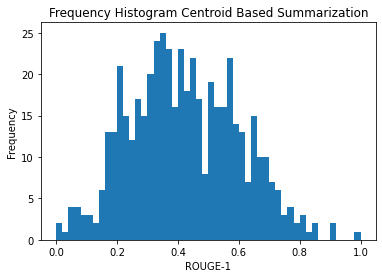

In [46]:
# Plot Histogram on x
plt.hist(Y_centroid, bins=50)
plt.gca().set(title='Frequency Histogram Centroid Based Summarization', ylabel='Frequency',xlabel='ROUGE-1');

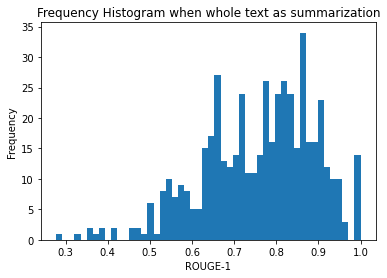

In [47]:
# Plot Histogram on x
plt.hist(Y_max, bins=50)
plt.gca().set(title='Frequency Histogram when whole text as summarization', ylabel='Frequency',xlabel='ROUGE-1');

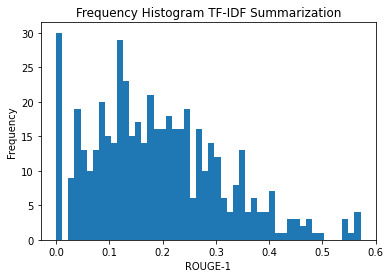

In [48]:
# Plot Histogram on x
plt.hist(Y_tfidf, bins=50)
plt.gca().set(title='Frequency Histogram TF-IDF Summarization', ylabel='Frequency',xlabel='ROUGE-1');